# Getting Started:
## A simple driving model training and evaluation pipeline using the Drive360 dataset and PyTorch.

## Loading data from Drive360 dataset.

The **dataset.py** file contains the 3 classes necessary for creating a Drive360Loader. Using the **config.json** file to specify the location of the csv and data directory, we can generate phase (train, validation, test) specific data loaders that can output samples from each set. Adjust the **dataset.py** to your preferred training framework.

In [26]:
import json
from dataset import Drive360Loader

# load the config.json file that specifies data 
# location parameters and other hyperparameters 
# required.
config = json.load(open('./config_sample3.json'))

# create a train, validation and test data loader
train_loader = Drive360Loader(config, 'train')
validation_loader = Drive360Loader(config, 'validation')
test_loader = Drive360Loader(config, 'test')

# print the data (keys) available for use. See full 
# description of each data type in the documents.
print('Loaded train loader with the following data available as a dict.')
print(train_loader.drive360.dataframe.keys())

Phase: train # of data: 38876
Phase: validation # of data: 2558
Phase: test # of data: 6957
Loaded train loader with the following data available as a dict.
Index(['cameraRight', 'cameraFront', 'cameraRear', 'cameraLeft', 'canSteering',
       'canSpeed', 'chapter'],
      dtype='object')


## Training a basic driving model

Create your driving model. This is specific to your learning framework. 

Below we give a very basic dummy model that uses the front facing camera and a resnet34 + LSTM architecture to predict canSteering and canSpeed. 

In [2]:
from torchvision import models
import torch.nn as nn
import torch

class SomeDrivingModelResnet101(nn.Module):
    def __init__(self):
        super(SomeDrivingModelResnet101, self).__init__()
        final_concat_size = 0
        
        # Main CNN
        cnn = models.resnet101(pretrained=True)
        self.features = nn.Sequential(*list(cnn.children())[:-1])
        self.intermediate = nn.Sequential(nn.Linear(
                          cnn.fc.in_features, 128),
                          nn.ReLU())
        final_concat_size += 128

        # Main LSTM
        self.lstm = nn.LSTM(input_size=128,
                            hidden_size=64,
                            num_layers=3,
                            batch_first=False)
        final_concat_size += 64
        
        # Angle Regressor
        self.control_angle = nn.Sequential(
            nn.Linear(final_concat_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        # Speed Regressor
        self.control_speed = nn.Sequential(
            nn.Linear(final_concat_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, data):
        module_outputs = []
        lstm_i = []
        # Loop through temporal sequence of
        # front facing camera images and pass 
        # through the cnn.
        for k, v in data['cameraFront'].items():
            v = v.cuda()
            x = self.features(v)
            x = x.view(x.size(0), -1)
            x = self.intermediate(x)
            lstm_i.append(x)
            # feed the current front facing camera
            # output directly into the 
            # regression networks.
            if k == 0:
                module_outputs.append(x)

        # Feed temporal outputs of CNN into LSTM
        i_lstm, _ = self.lstm(torch.stack(lstm_i))
        module_outputs.append(i_lstm[-1])
        
        # Concatenate current image CNN output 
        # and LSTM output.
        x_cat = torch.cat(module_outputs, dim=-1)
        
        # Feed concatenated outputs into the 
        # regession networks.
        prediction = {'canSteering': torch.squeeze(self.control_angle(x_cat)),
                      'canSpeed': torch.squeeze(self.control_speed(x_cat))}
        return prediction
    
class SomeDrivingModelResnet50(nn.Module):
    def __init__(self):
        super(SomeDrivingModelResnet50, self).__init__()
        final_concat_size = 0
        
        # Main CNN
        cnn = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(cnn.children())[:-1])
        self.intermediate = nn.Sequential(nn.Linear(
                          cnn.fc.in_features, 128),
                          nn.ReLU())
        final_concat_size += 128

        # Main LSTM
        self.lstm = nn.LSTM(input_size=128,
                            hidden_size=64,
                            num_layers=3,
                            batch_first=False)
        final_concat_size += 64
        
        # Angle Regressor
        self.control_angle = nn.Sequential(
            nn.Linear(final_concat_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        # Speed Regressor
        self.control_speed = nn.Sequential(
            nn.Linear(final_concat_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, data):
        module_outputs = []
        lstm_i = []
        # Loop through temporal sequence of
        # front facing camera images and pass 
        # through the cnn.
        for k, v in data['cameraFront'].items():
            v = v.cuda()
            x = self.features(v)
            x = x.view(x.size(0), -1)
            x = self.intermediate(x)
            lstm_i.append(x)
            # feed the current front facing camera
            # output directly into the 
            # regression networks.
            if k == 0:
                module_outputs.append(x)

        # Feed temporal outputs of CNN into LSTM
        i_lstm, _ = self.lstm(torch.stack(lstm_i))
        module_outputs.append(i_lstm[-1])
        
        # Concatenate current image CNN output 
        # and LSTM output.
        x_cat = torch.cat(module_outputs, dim=-1)
        
        # Feed concatenated outputs into the 
        # regession networks.
        prediction = {'canSteering': torch.squeeze(self.control_angle(x_cat)),
                      'canSpeed': torch.squeeze(self.control_speed(x_cat))}
        return prediction

A basic training procedure that iterates over the train_loader and feeds each sample into our dummy model, subsequently calculates loss. We kill after 20 batches just

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt

def train_model(model, optimizer, criterion_speed, criterion_steering, epochs):
    hist_train_loss_speed = []
    hist_train_loss_steering = []
    hist_train_loss_total = []
    model.cuda()
    for epoch in range(epochs):
        start = time.time()
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):

            optimizer.zero_grad()
            prediction = model(data)

            steering_loss = criterion_steering(prediction['canSteering'].cuda(), target['canSteering'].cuda())
            speed_loss = criterion_speed(prediction['canSpeed'].cuda(), target['canSpeed'].cuda())
            loss = steering_loss + speed_loss
            hist_train_loss_total.append(loss.cpu().detach().numpy())
            hist_train_loss_speed.append(speed_loss.cpu().detach().numpy())
            hist_train_loss_steering.append(steering_loss.cpu().detach().numpy())
            
            loss.backward()
            optimizer.step()
        end = time.time() 
        print("Training minutes elapsed epoch{}: {}".format(epoch, round((end - start) / 60, 2)))

        model.eval()

        speed_sum = 0
        steering_sum = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(validation_loader):
                optimizer.zero_grad()
                prediction = model(data)
                speed_dif = prediction['canSpeed'].cpu() - target['canSpeed']
                steering_dif = prediction['canSteering'].cpu() - target['canSteering']
                speed_sum += (np.square(speed_dif)).mean()
                steering_sum += (np.square(steering_dif)).mean()
        print("Steering Error: {}\nSpeed Error: {}".format(float(steering_sum), float(speed_sum)))
    
    plt.plot(hist_train_loss_speed)
    plt.title("Speed Loss")
    plt.show()
    plt.plot(hist_train_loss_steering)
    plt.title("Steering Loss")
    plt.show()
    plt.plot(hist_train_loss_total)
    plt.title("Total Loss")
    plt.show()

## Local evaluation of the model.

In [4]:
def cross_validation(user_models, optimizers, criterion_speeds, criterion_steerings, index, name):
    print(name + ": ")
    train_model(user_models[index], optimizers[index], criterion_speeds[index], criterion_steerings[index], 50)
    print("--------------------------------------------------------------")

(Resnet50 Model, AdamW optimizer LR-0.0001, SmoothL1Loss): 
Training minutes elapsed epoch0: 6.72
Steering Error: 6.907321929931641
Speed Error: 4.568939685821533
Training minutes elapsed epoch1: 6.11
Steering Error: 5.360325336456299
Speed Error: 4.834249019622803
Training minutes elapsed epoch2: 8.87
Steering Error: 5.619451999664307
Speed Error: 4.7432074546813965
Training minutes elapsed epoch3: 8.66
Steering Error: 6.168062210083008
Speed Error: 4.540382385253906
Training minutes elapsed epoch4: 8.49
Steering Error: 6.328887939453125
Speed Error: 4.623596668243408
Training minutes elapsed epoch5: 6.26
Steering Error: 5.31678581237793
Speed Error: 4.03985595703125
Training minutes elapsed epoch6: 5.92
Steering Error: 5.111908912658691
Speed Error: 4.369528770446777
Training minutes elapsed epoch7: 5.86
Steering Error: 5.410534858703613
Speed Error: 4.1691575050354
Training minutes elapsed epoch8: 5.94
Steering Error: 4.292539119720459
Speed Error: 4.212906837463379
Training minutes

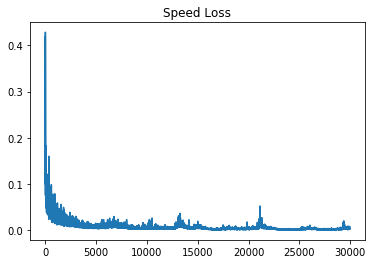

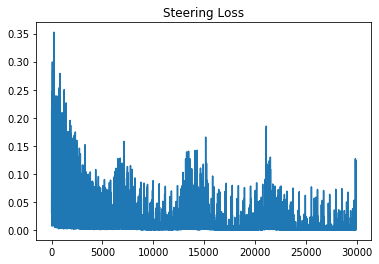

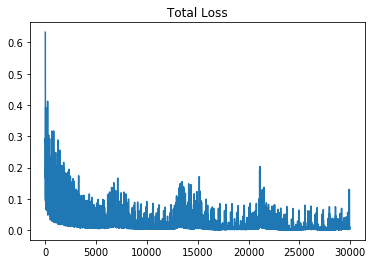

--------------------------------------------------------------


In [5]:
import torch.optim as optim

user_models = [SomeDrivingModelResnet101(), SomeDrivingModelResnet50(), SomeDrivingModelResnet50(), SomeDrivingModelResnet50()]
optimizers = [optim.AdamW(user_models[0].parameters()),
             optim.AdamW(user_models[1].parameters(), lr=0.0001),
             optim.AdamW(user_models[2].parameters(), lr=0.001),
             optim.AdamW(user_models[3].parameters(), lr=0.01)]
criterion_speeds = [nn.SmoothL1Loss(), nn.SmoothL1Loss(), nn.SmoothL1Loss(), nn.SmoothL1Loss()]
criterion_steerings = [nn.SmoothL1Loss(), nn.SmoothL1Loss(), nn.SmoothL1Loss(), nn.SmoothL1Loss()]

#cross_validation(user_models, optimizers, criterion_speeds, criterion_steerings, 0, 
#                 "(Resnet101 Model, SGD optimizer, SmoothL1Loss)")

cross_validation(user_models, optimizers, criterion_speeds, criterion_steerings, 1, 
                 "(Resnet50 Model, AdamW optimizer LR-0.0001, SmoothL1Loss)")

#cross_validation(user_models, optimizers, criterion_speeds, criterion_steerings, 2, 
#                 "(Resnet50 Model, AdamW optimizer, SmoothL1Loss)")

#cross_validation(user_models, optimizers, criterion_speeds, criterion_steerings, 3, 
#                 "(Resnet50 Model, AdamW optimizer, SmoothL1Loss)")

## Creating a submission file.

In [33]:
normalize_targets = config['target']['normalize']
target_mean = config['target']['mean']
target_std = config['target']['std']

def add_results(results, output):
    steering = np.squeeze(output['canSteering'].cpu().data.numpy())
    speed = np.squeeze(output['canSpeed'].cpu().data.numpy())
    if normalize_targets:
        steering = (steering*target_std['canSteering'])+target_mean['canSteering']
        speed = (speed*target_std['canSpeed'])+target_mean['canSpeed']
    if np.isscalar(steering):
        steering = [steering]
    if np.isscalar(speed):
        speed = [speed]
    results['canSteering'].extend(steering)
    results['canSpeed'].extend(speed)

test_chapter_length = [2997 for i in range(98)]
test_chapter_length[14] = 2996
test_chapter_length[36] = 2996
test_chapter_length[38] = 2996
test_chapter_length[63] = 1277
test_chapter_length[64] = 2861
test_chapter_length[66] = 2014
test_chapter_length[70] = 2996
test_chapter_length[72] = 2690
test_chapter_length[81] = 2106
test_chapter_length[85] = 2996
test_chapter_length[92] = 2996

for i in range(len(test_chapter_length)):
    test_chapter_length[i] -= 100
    
print("Number of test data: {}".format(sum(test_chapter_length)))

Number of test data: 279863


We use pandas to create a submission file which is simply a 2-column csv with a canSteering and canSpeed prediction for each row in the **drive360_test.csv** a total of 305437 rows/predictions not including the header. See the **sample_submission.csv** file as an example.

IMPORTANT: for the test phase indices will start 10s (100 samples) into each chapter this is to allow challenge participants to experiment with different temporal settings of data input. If challenge participants have a greater temporal length than 10s for each training sample, then they must write a custom function here. Please check out the **dataset.py** file for additional explanation.

In [47]:
import pandas as pd

def create_submission(model_index, interval, file_name):
    file = './' + file_name + '.csv'
    results = {'canSteering': [],
               'canSpeed': []}

    final_result = {'canSteering': np.zeros(279863, dtype="float64"),
                    'canSpeed': np.zeros(279863, dtype="float64")}
    final_result['canSteering'][:] = np.nan
    final_result['canSpeed'][:] = np.nan


    start = time.time()
    print("Start creating submission file " + file)
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            prediction = user_models[model_index](data)
            add_results(results, prediction)
    
    index = 0
    chapter_cap = 0
    r_index = 0
    for chapter_num in test_chapter_length:
        index = chapter_cap + 19
        
        #Fill the leading indices
        final_result['canSteering'][chapter_cap] = results['canSteering'][r_index]
        final_result['canSpeed'][chapter_cap] = results['canSpeed'][r_index]
        
        chapter_cap += chapter_num
        while index < chapter_cap:
            final_result['canSteering'][index] = results['canSteering'][r_index]
            final_result['canSpeed'][index] = results['canSpeed'][r_index]
            
            index += interval
            r_index += 1
            
        #Fill the trailing indices
        #print(index, chapter_cap, r_index)
        final_result['canSteering'][chapter_cap - 1] = results['canSteering'][r_index - 1]
        final_result['canSpeed'][chapter_cap - 1] = results['canSpeed'][r_index - 1]

    df = pd.DataFrame.from_dict(final_result, dtype='float64')
    df.interpolate(method='linear', limit_direction='forward', inplace=True)
    df.to_csv(file, index=False)

    end = time.time() 
    print("Minutes elapsed: {}".format(round((end - start) / 60, 2)))
    
    return final_result
    
#create_submission(0, 40, "submissions_0")
r = create_submission(1, 40, "submissions_1")
#create_submission(2, 40, "submissions_2")
#create_submission(3, 40, "submissions_3")

Start creating submission file ./submissions_1.csv
2899 2897 72
5796 5794 144
8693 8691 216
11590 11588 288
14487 14485 360
17384 17382 432
20281 20279 504
23178 23176 576
26075 26073 648
28972 28970 720
31869 31867 792
34766 34764 864
37663 37661 936
40560 40558 1008
43457 43454 1080
46353 46351 1152
49250 49248 1224
52147 52145 1296
55044 55042 1368
57941 57939 1440
60838 60836 1512
63735 63733 1584
66632 66630 1656
69529 69527 1728
72426 72424 1800
75323 75321 1872
78220 78218 1944
81117 81115 2016
84014 84012 2088
86911 86909 2160
89808 89806 2232
92705 92703 2304
95602 95600 2376
98499 98497 2448
101396 101394 2520
104293 104291 2592
107190 107187 2664
110086 110084 2736
112983 112980 2808
115879 115877 2880
118776 118774 2952
121673 121671 3024
124570 124568 3096
127467 127465 3168
130364 130362 3240
133261 133259 3312
136158 136156 3384
139055 139053 3456
141952 141950 3528
144849 144847 3600
147746 147744 3672
150643 150641 3744
153540 153538 3816
156437 156435 3888
159334 1593